In [355]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta
from datetime import date
import matplotlib as plt
from itertools import product
import openpyxl

# importing historical data for backtest
def get1minBars(csvName):
    
    priceData1minBars_df = pd.read_csv(csvName, usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
    
    # Parse datetime column and divide in 2 columns
    # SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
    priceData1minBars_df.rename(columns={
        'date': 'datetime'
    }, inplace=True)
    
    priceData1minBars_df['datetime'] = pd.to_datetime(priceData1minBars_df['datetime'])
    
    priceData1minBars_df['Date'] = priceData1minBars_df['datetime'].dt.date
    priceData1minBars_df['Time'] = priceData1minBars_df['datetime'].dt.time
    
    # sorting the data by the time column to make sure it is consistent
    priceData1minBars_df.sort_values('datetime', inplace=True)
    
    # Drop original 'date' column
    # SPY_Data.drop(columns=['date'], inplace=True)
    
    # Filter for regular trading hours using datetime column
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time >= pd.to_datetime("09:30").time()]
    # priceData1minBars_df = priceData1minBars_df[priceData1minBars_df['datetime'].dt.time <= pd.to_datetime("16:00").time()]
    
    # Making sure the order of the columns stays the same 
    priceData1minBars_df = priceData1minBars_df[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
    
    return priceData1minBars_df
    
    


In [357]:
QQQ_Data = get1minBars('NQ_1min_master.csv')
# QQQ_Data = QQQ_Data[472980:483000]
QQQ_Data = QQQ_Data[:int(len(QQQ_Data)/2)]
QQQ_Data

,Date,Time,open,high,low,close,volume
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175
1,2023-11-01,22:01:00,14760.50,14764.00,14760.50,14762.00,156
2,2023-11-01,22:02:00,14762.25,14762.25,14760.50,14761.25,48
3,2023-11-01,22:03:00,14761.25,14762.00,14760.75,14761.00,30
4,2023-11-01,22:04:00,14761.75,14763.00,14761.00,14762.25,52
...,...,...,...,...,...,...,...
353281,2024-10-31,15:47:00,20059.50,20060.00,20042.25,20047.50,2006
353282,2024-10-31,15:48:00,20047.50,20052.00,20035.75,20042.75,2235
353283,2024-10-31,15:49:00,20042.50,20044.75,20036.25,20040.25,1373
353284,2024-10-31,15:50:00,20040.25,20046.75,20034.00,20040.00,1524


In [358]:
def find_candle_streaks(df, min_streak=4):
    """
    Detects streaks of consecutive candles going in the same direction.
    Adds a column 'streak_dir' (+1 for green, -1 for red) and 'streak_len'.

    Parameters
    ----------
    df : DataFrame with 'open' and 'close' columns.
    min_streak : int, minimum streak length to flag.

    Returns
    -------
    streaks_df : subset of df where a streak of length >= min_streak ends.
    """
    df = df.copy()

    # Direction of each candle (+1 = green, -1 = red, 0 = doji)
    df['dir'] = np.sign(df['close'] - df['open'])
    df['dir'].replace(0, np.nan, inplace=True)  # ignore dojis

    # Compute consecutive direction streak lengths
    streak_len = []
    curr_len = 1
    for i in range(1, len(df)):
        if df['dir'].iloc[i] == df['dir'].iloc[i-1]:
            curr_len += 1
        else:
            curr_len = 1
        streak_len.append(curr_len)
    streak_len.insert(0, 1)  # first bar

    df['streak_len'] = streak_len
    df['streak_dir'] = df['dir']

    # Keep only where streak just reached or exceeded threshold
    streaks_df = df[df['streak_len'] >= min_streak].copy()

    return streaks_df

streaks = find_candle_streaks(QQQ_Data, min_streak=6)
streaks

,Date,Time,open,high,low,close,volume,dir,streak_len,streak_dir
51,2023-11-01,22:51:00,14769.25,14771.25,14769.25,14770.75,69,1.0,6,1.0
79,2023-11-01,23:19:00,14788.75,14796.00,14788.50,14789.75,609,1.0,6,1.0
92,2023-11-01,23:32:00,14778.50,14778.75,14776.75,14778.00,87,-1.0,6,-1.0
319,2023-11-02,03:19:00,14808.00,14809.00,14808.00,14808.75,22,1.0,6,1.0
392,2023-11-02,04:32:00,14804.75,14804.75,14803.50,14804.50,33,-1.0,6,-1.0
...,...,...,...,...,...,...,...,...,...,...
353162,2024-10-31,13:48:00,20218.00,20221.75,20201.00,20202.75,3521,-1.0,7,-1.0
353163,2024-10-31,13:49:00,20203.00,20204.00,20174.25,20179.00,4866,-1.0,8,-1.0
353164,2024-10-31,13:50:00,20178.00,20185.75,20158.75,20160.75,3639,-1.0,9,-1.0
353204,2024-10-31,14:30:00,20140.75,20142.50,20122.75,20124.75,2275,-1.0,6,-1.0


In [359]:
def add_ema10_atr10(df, atr_per_session=True):
    """
    Adds:
      - 'ema10' on close (continuous)
      - 'atr10' (Wilder's ATR). By default, resets each session (per Date).

    Expects columns: ['Date','Time','open','high','low','close','volume'].
    Returns the same df with two new columns.
    """
    out = df.copy()
    out[['open','high','low','close']] = out[['open','high','low','close']].astype(float)

    # --- EMA(10) on close (continuous) ---
    out['ema10'] = out['close'].ewm(span=10, adjust=False).mean()

    # --- ATR(10) (Wilder) ---
    if atr_per_session:
        # prev close within the same Date/session
        prev_close = out.groupby('Date')['close'].shift(1)
    else:
        prev_close = out['close'].shift(1)

    # True Range
    tr1 = (out['high'] - out['low']).abs()
    tr2 = (out['high'] - prev_close).abs()
    tr3 = (out['low']  - prev_close).abs()
    tr = np.maximum(tr1, np.maximum(tr2, tr3))
    # first bar of a session: prev_close is NaN → fall back to high-low
    tr = tr.fillna(tr1)

    if atr_per_session:
        out['atr10'] = (
            tr.groupby(out['Date'])
              .transform(lambda s: s.ewm(alpha=1/10, adjust=False).mean())
        )
    else:
        out['atr10'] = tr.ewm(alpha=1/10, adjust=False).mean()

    return out


def mark_pullback_candles(df):
    """
    Marks:
      - green_pullback: green candle after red, with lower high & lower low than prior red
      - red_pullback: red candle after green, with higher high & higher low than prior green
    Returns df with 2 new boolean columns.
    """

    df = df.copy()

    # determine color of each candle
    df['is_green'] = df['close'] > df['open']
    df['is_red']   = df['close'] < df['open']

    # shift previous candle values
    prev_close = df['close'].shift(1)
    prev_open  = df['open'].shift(1)
    prev_high  = df['high'].shift(1)
    prev_low   = df['low'].shift(1)

    prev_is_green = prev_close > prev_open
    prev_is_red   = prev_close < prev_open

    # condition 1: green candle after red
    cond1 = prev_is_red
    cond2 = (df['low'] < prev_low) & (df['high'] < prev_high)
    cond3 = df['is_green']
    df['green_pullback'] = cond1 & cond2 & cond3

    # condition 2: red candle after green
    cond1r = prev_is_green
    cond2r = (df['low'] > prev_low) & (df['high'] > prev_high)
    cond3r = df['is_red']
    df['red_pullback'] = cond1r & cond2r & cond3r
    
        
    return df

def add_entry_signals(df):
    """
    Marks entries when:
      - LONG signal: green_pullback & close > ema10
      - SHORT signal: red_pullback  & close < ema10
    Then schedules the entry at the *next* bar's open (per Date/session).
    Adds columns:
      - signal: {+1 long, -1 short, 0 none} at the signal bar
      - entryNextOpen: True on the bar where you would enter (next bar)
      - side: {+1, -1, 0} aligned with entryNextOpen
      - entry_price: open price on the entry bar (NaN otherwise)
    """
    df = df.copy()

    # vectorized signal at the *current* bar
    cond_long  = df['green_pullback'] & (df['close'] > df['ema10'])
    cond_short = df['red_pullback']   & (df['close'] < df['ema10'])
    df['signal'] = np.select([cond_long, cond_short], [1, -1], default=0)

    # shift the signal so the entry is at the next bar's open, per session (Date)
    df['side'] = df.groupby('Date')['signal'].shift(1).fillna(0).astype(int)

    # entry flags & entry price on the bar where you'd actually execute
    df['entryNextOpen'] = df['side'] != 0
    df['entry_price']   = np.where(df['entryNextOpen'], df['open'], np.nan)
    
    return df


def add_targets_and_stops(df, atr_mult=0.5, use_prior_atr=True):
    """
    On the bar where entry occurs (entryNextOpen=True):
      - Long:  target = entry_price + atr_used * atr_mult
      - Short: target = entry_price - atr_used * atr_mult
    By default, atr_used is the ATR from the *previous* bar to prevent look-ahead.
    Also adds a symmetric stop for convenience.
    """
    out = df.copy()

    # ATR to use on the entry bar
    if use_prior_atr:
        # use ATR from the prior bar within the same session
        atr_used = out.groupby('Date')['atr10'].shift(1)
    else:
        # use ATR from the entry bar itself (can introduce slight look-ahead if ATR updates with the bar)
        atr_used = out['atr10']

    # initialize
    out['targetPrice'] = np.nan
    out['stopPrice']   = np.nan

    long_mask  = (out['entryNextOpen']) & (out['side'] == 1)
    short_mask = (out['entryNextOpen']) & (out['side'] == -1)

    out.loc[long_mask,  'targetPrice'] = out.loc[long_mask,  'entry_price'] + atr_used.loc[long_mask]  * atr_mult
    out.loc[short_mask, 'targetPrice'] = out.loc[short_mask, 'entry_price'] - atr_used.loc[short_mask] * atr_mult

    # optional: symmetric stop
    out.loc[long_mask,  'stopPrice']   = out.loc[long_mask,  'entry_price'] - atr_used.loc[long_mask]  * atr_mult
    out.loc[short_mask, 'stopPrice']   = out.loc[short_mask, 'entry_price'] + atr_used.loc[short_mask] * atr_mult

    return out


scalpQQQ = add_ema10_atr10(QQQ_Data, atr_per_session=True)
scalpQQQ = mark_pullback_candles(scalpQQQ)
scalpQQQ = add_entry_signals(scalpQQQ)
scalpQQQ = add_targets_and_stops(scalpQQQ)
scalpQQQ

,Date,Time,open,high,low,close,volume,ema10,atr10,is_green,is_red,green_pullback,red_pullback,signal,side,entryNextOpen,entry_price,targetPrice,stopPrice
0,2023-11-01,22:00:00,14761.25,14763.50,14760.00,14760.00,175,14760.000000,3.500000,False,True,False,False,0,0,False,NaN,NaN,NaN
1,2023-11-01,22:01:00,14760.50,14764.00,14760.50,14762.00,156,14760.363636,3.550000,True,False,False,False,0,0,False,NaN,NaN,NaN
2,2023-11-01,22:02:00,14762.25,14762.25,14760.50,14761.25,48,14760.524793,3.370000,False,True,False,False,0,0,False,NaN,NaN,NaN
3,2023-11-01,22:03:00,14761.25,14762.00,14760.75,14761.00,30,14760.611195,3.158000,False,True,False,False,0,0,False,NaN,NaN,NaN
4,2023-11-01,22:04:00,14761.75,14763.00,14761.00,14762.25,52,14760.909159,3.042200,True,False,False,False,0,0,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353281,2024-10-31,15:47:00,20059.50,20060.00,20042.25,20047.50,2006,20061.660314,12.815486,False,True,False,False,0,0,False,NaN,NaN,NaN
353282,2024-10-31,15:48:00,20047.50,20052.00,20035.75,20042.75,2235,20058.222075,13.158938,False,True,False,False,0,0,False,NaN,NaN,NaN
353283,2024-10-31,15:49:00,20042.50,20044.75,20036.25,20040.25,1373,20054.954425,12.693044,False,True,False,False,0,0,False,NaN,NaN,NaN
353284,2024-10-31,15:50:00,20040.25,20046.75,20034.00,20040.00,1524,20052.235439,12.698740,False,True,False,False,0,0,False,NaN,NaN,NaN


In [361]:
import pandas as pd
import numpy as np


def _round_tick(x, tick, how="nearest"):
        if pd.isna(x):
            return x
        r = x / tick
        if how == "nearest":
            return tick * np.round(r)
        elif how == "up":
            # tiny epsilon guards against floating drift (e.g., 100.999999)
            return tick * np.ceil(r - 1e-12)
        elif how == "down":
            return tick * np.floor(r + 1e-12)
        else:
            raise ValueError("how must be one of {'nearest','up','down'}")
        
        
        
# def add_ema10_atr10(df, atr_per_session=True):
#     """
#     Adds:
#       - 'ema10' on close (continuous)
#       - 'atr10' (Wilder's ATR). By default, resets each session (per Date).
# 
#     Expects columns: ['Date','Time','open','high','low','close','volume'].
#     Returns the same df with two new columns.
#     """
#     out = df.copy()
#     out[['open','high','low','close']] = out[['open','high','low','close']].astype(float)
# 
#     # --- EMA(10) on close (continuous) ---
#     out['ema10'] = out['close'].ewm(span=10, adjust=False).mean()
# 
#     # --- ATR(10) (Wilder) ---
#     out['prev_close'] = out['close'].shift(1)
# 
#     # True Range
#     tr1 = (out['high'] - out['low']).abs()
#     tr2 = (out['high'] - out['prev_close']).abs()
#     tr3 = (out['low']  - out['prev_close']).abs()
#     tr = np.maximum(tr1, np.maximum(tr2, tr3))
#     # first bar of a session: prev_close is NaN → fall back to high-low
#     tr = tr.fillna(tr1)
# 
#     if atr_per_session:
#         out['atr10'] = (
#             tr.groupby(out['Date'])
#               .transform(lambda s: s.ewm(alpha=1/10, adjust=False).mean())
#         )
#     else:
#         out['atr10'] = tr.ewm(alpha=1/10, adjust=False).mean()
# 
#     return out
# 
# test123 = add_ema10_atr10(QQQ_Data)

def backtest_scalp_pullback(
    df,
    ema_col="ema10",
    atr_col="atr10",
    slippage=0.50,
    atr_stop_mult=0.5,
    atr_target_mult=0.5,
    session_col="Date",   # can be a date-like column to separate days
    time_col="Time",       # optional, used only to keep outputs informative
    tick_size = 0.25
):
    """
    EMA10/ATR10 pullback scalping backtest with stop & target exits.

    Assumptions / Rules
    -------------------
    Entry logic (computed on bar t, enter at next bar open t+1):
      Long setup ("green pullback"):
        1) Previous bar (t-1) was red (close < open)
        2) Current bar (t) is green (close > open)
        3) Current bar makes a LOWER HIGH and LOWER LOW than previous bar (classic pullback)
        4) Current bar closes ABOVE EMA10

      Short setup ("red pullback"):
        1) Previous bar (t-1) was green (close > open)
        2) Current bar (t) is red (close < open)
        3) Current bar makes a HIGHER HIGH and HIGHER LOW than previous bar
        4) Current bar closes BELOW EMA10

    Execution:
      - Enter at next bar's open (t+1 open) +/- slippage (added 2 ticks (0.25 * 2) to ask for long, minus 2 ticks (0.25 * 2) for short).
      - Set target at entry using ATR and stop as the signal bar's low/high of -/+ 1 tick:
          long: stop = low - 1 tick, target = entry + atr_target_mult * ATR
          short: stop = high + 1 tick, target = entry - atr_target_mult * ATR
      - While in a position, check each subsequent bar's OHLC:
          * If both stop and target lie within the same bar's range:
                Use conservative assumption: STOP is hit first.
          * Else, if only one is breached by that bar's range, exit there.
      - On exit, PnL = side * (exit_price - entry_price)

    Inputs
    ------
    df : DataFrame with columns ['open','high','low','close', ema_col, atr_col] and session/time columns.
    slippage : absolute price amount added to entry cost (long pays +slip, short pays +slip).
    atr_stop_mult : low/high of signal bar -/+ 1 tick
    atr_target_mult : multiple of ATR for target

    Returns
    -------
    trades : DataFrame of all completed trades with details.
    stats  : dict of basic performance metrics.
    """

    # Defensive copy and ensure needed columns exist
    req_cols = {"open","high","low","close", ema_col, atr_col, session_col}
    missing = req_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    data = df.copy()
    data = data.sort_values([session_col, time_col] if time_col in data.columns else [session_col]).reset_index(drop=True)

    # Candle colors
    data["is_green"] = data["close"] > data["open"]
    data["is_red"]   = data["close"] < data["open"]

    # Previous bar OHLC for pullback structure
    data["prev_high"] = data["high"].shift(1)
    data["prev_low"]  = data["low"].shift(1)
    data["prev_green"] = data["is_green"].shift(1)
    data["prev_red"]   = data["is_red"].shift(1)

    # Pullback patterns (evaluated on bar t)
    # Long: green bar after red, with lower high & lower low vs prev bar, and closes above EMA
    data["green_pullback"] = (
        (data["prev_red"] == True) &
        (data["is_green"] == True) &
        (data["high"] < data["prev_high"]) &
        (data["low"]  < data["prev_low"]) &
        (data["close"] > data[ema_col])
    )

    # Short: red bar after green, with higher high & higher low vs prev bar, and closes below EMA
    data["red_pullback"] = (
        (data["prev_green"] == True) &
        (data["is_red"] == True) &
        (data["high"] > data["prev_high"]) &
        (data["low"]  > data["prev_low"]) &
        (data["close"] < data[ema_col])
    )

    # Signal bar index t; we enter next bar open (t+1)
    data["entry_signal"] = np.where(data["green_pullback"], 1,
                            np.where(data["red_pullback"], -1, 0))

    trades = []
    in_pos = False
    side = 0
    entry_price = np.nan
    stop = np.nan
    target = np.nan
    entry_idx = None
    entry_date = None

    # Iterate row by row
    for i in range(len(data)-1):  # we need i+1 for entry
        row = data.iloc[i]
        nxt = data.iloc[i+1]

        # If not in a position, can arm an entry for next bar open
        if not in_pos:
            if row["entry_signal"] == 1:
                # Long entry at next open + slippage
                side = 1
                entry_price = float(nxt["open"]) + float(slippage)
                atr = float(nxt[atr_col]) if pd.notna(nxt[atr_col]) else float(row[atr_col])
                stop = row['low'] - 0.25
                target = entry_price + atr_target_mult * atr 
                target = _round_tick(target, tick_size)
                entry_idx = i+1
                entry_date = nxt[session_col]
                in_pos = True

            elif row["entry_signal"] == -1:
                # Short entry at next open + slippage (cost to cross)
                side = -1
                entry_price = float(nxt["open"]) - float(slippage)
                atr = float(nxt[atr_col]) if pd.notna(nxt[atr_col]) else float(row[atr_col])
                stop = row['high'] + 0.25
                target = entry_price - atr_target_mult * atr
                target = _round_tick(target, tick_size)
                entry_idx = i+1
                entry_date = nxt[session_col]
                in_pos = True

        else:
            # Manage open position starting from current row (i) bar range
            hi = float(row["high"])
            lo = float(row["low"])

            exit_reason = None
            exit_price = None

            if side == 1:
                # Long: stop below, target above
                hit_stop = lo <= stop
                hit_tgt  = hi + 0.25 >= target
                if hit_stop and hit_tgt:
                    # Conservative: stop first
                    exit_price = stop - slippage
                    exit_reason = "stop_same_bar"
                elif hit_stop:
                    exit_price = stop - slippage
                    exit_reason = "stop"
                elif hit_tgt:
                    exit_price = target
                    exit_reason = "target"

            elif side == -1:
                # Short: stop above, target below
                hit_stop = hi >= stop
                hit_tgt  = lo - 0.25 <= target
                if hit_stop and hit_tgt:
                    exit_price = stop + slippage
                    exit_reason = "stop_same_bar"
                elif hit_stop:
                    exit_price = stop + slippage
                    exit_reason = "stop"
                elif hit_tgt:
                    exit_price = target
                    exit_reason = "target"

            # If neither stop nor target hit on this bar, continue
            if exit_price is not None:
                pnl = (exit_price - entry_price) * side
                trades.append({
                    "entry_idx": entry_idx,
                    "exit_idx": i,
                    "entry_time": data.iloc[entry_idx][time_col] if time_col in data.columns else None,
                    "exit_time": row[time_col] if time_col in data.columns else None,
                    "entry_date": entry_date,
                    "exit_date": row[session_col],
                    "side": side,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "stop": stop,
                    "target": target,
                    "exit_reason": exit_reason,
                    "pnl": pnl,
                    'ATR': atr
                })
                # Reset state
                in_pos = False
                side = 0
                entry_price = np.nan
                stop = np.nan
                target = np.nan
                entry_idx = None
                entry_date = None

    trades_df = pd.DataFrame(trades)

    # Basic stats
    if len(trades_df):
        wins = trades_df["pnl"] > 0
        losses = trades_df["pnl"] < 0
        gp = trades_df.loc[wins, "pnl"].sum()
        gl = trades_df.loc[losses, "pnl"].sum()
        stats = {
            "n_trades": int(len(trades_df)),
            "win_rate": float(wins.mean()),
            "avg_win": float(trades_df.loc[wins, "pnl"].mean()) if wins.any() else 0.0,
            "avg_loss": float(trades_df.loc[losses, "pnl"].mean()) if losses.any() else 0.0,
            "payoff_ratio": (trades_df.loc[wins, "pnl"].mean() / abs(trades_df.loc[losses, "pnl"].mean()))
                             if (wins.any() and losses.any()) else np.nan,
            "profit_factor": (gp / abs(gl)) if gl < 0 else np.nan,
            "total_pnl": float(trades_df["pnl"].sum()),
            "median_pnl": float(trades_df["pnl"].median()),
            "max_drawdown": float((trades_df["pnl"].cumsum().cummax() - trades_df["pnl"].cumsum()).max())
        }
    else:
        stats = {
            "n_trades": 0, "win_rate": np.nan, "avg_win": np.nan, "avg_loss": np.nan,
            "payoff_ratio": np.nan, "profit_factor": np.nan, "total_pnl": 0.0,
            "median_pnl": np.nan, "max_drawdown": 0.0
        }

    return trades_df, stats


In [362]:
trades_df, stats_ = backtest_scalp_pullback(scalpQQQ)

In [363]:
trades_df

,entry_idx,exit_idx,entry_time,exit_time,entry_date,exit_date,side,entry_price,exit_price,stop,target,exit_reason,pnl,ATR
0,12,12,22:12:00,22:12:00,2023-11-01,2023-11-01,1,14767.75,14769.25,14765.25,14769.25,target,1.50,2.846307
1,59,59,22:59:00,22:59:00,2023-11-01,2023-11-01,-1,14769.00,14768.00,14770.25,14768.00,target,1.00,1.831732
2,73,73,23:13:00,23:13:00,2023-11-01,2023-11-01,1,14778.25,14775.50,14776.00,14779.50,stop,-2.75,2.478441
3,123,125,00:03:00,00:05:00,2023-11-02,2023-11-02,1,14790.75,14786.50,14787.00,14794.75,stop,-4.25,7.820750
4,136,137,00:16:00,00:17:00,2023-11-02,2023-11-02,-1,14784.50,14787.00,14786.50,14782.50,stop,-2.50,4.155315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15092,353178,353178,14:04:00,14:04:00,2024-10-31,2024-10-31,-1,20144.75,20156.00,20155.50,20133.75,stop,-11.25,21.868211
15093,353212,353213,14:38:00,14:39:00,2024-10-31,2024-10-31,-1,20126.00,20118.00,20139.25,20118.00,target,8.00,16.051455
15094,353228,353235,14:54:00,15:01:00,2024-10-31,2024-10-31,-1,20078.75,20070.75,20098.00,20070.75,target,8.00,15.967996
15095,353260,353260,15:26:00,15:26:00,2024-10-31,2024-10-31,1,20103.25,20111.00,20086.00,20111.00,target,7.75,15.429201


In [364]:
# rebuild EMA and ATR to make sure there is no future leak
# look at optimizing the ATR signal

test = trades_df[(trades_df['ATR'] > 10) & (trades_df['ATR'] < 30)]
print(test['pnl'].sum())

print(len(test))
print(len(test[test['pnl']>0])/len(test))

-1511.5
2904
0.5640495867768595


In [365]:

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / (len(wins) + len(losses)))
    loss_rate = float(len(losses) / (len(wins) + len(losses)))

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean() - 0.04) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats #, equity, drawdown


n_trades                 2904.000000
win_rate                    0.564050
avg_win                     7.429029
avg_loss                  -10.805885
payoff_ratio                0.687498
expectancy_per_trade       -0.520489
gross_profit            12168.750000
gross_loss              13680.250000
profit_factor               0.889512
total_pnl               -1511.500000
median_pnl                  5.250000
max_drawdown            -1527.750000
sharpe_per_trade           -3.048679
dtype: float64


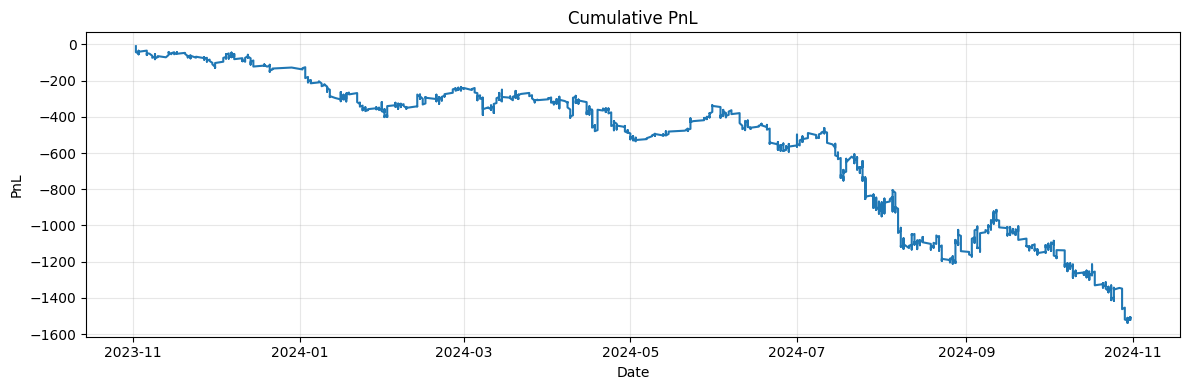

,entry_idx,exit_idx,entry_time,exit_time,entry_date,exit_date,side,entry_price,exit_price,stop,target,exit_reason,pnl,ATR,Date
30,949,949,13:49:00,13:49:00,2023-11-02,2023-11-02,-1,14907.50,14917.50,14917.00,14900.75,stop,-10.00,13.552970,2023-11-02
31,951,952,13:51:00,13:52:00,2023-11-02,2023-11-02,-1,14917.75,14927.00,14926.50,14911.25,stop,-9.25,13.210405,2023-11-02
32,954,954,13:54:00,13:54:00,2023-11-02,2023-11-02,-1,14916.00,14909.25,14929.00,14909.25,target,6.75,13.586886,2023-11-02
33,976,976,14:16:00,14:16:00,2023-11-02,2023-11-02,-1,14878.00,14888.00,14887.50,14871.00,stop,-10.00,14.151642,2023-11-02
34,991,991,14:31:00,14:31:00,2023-11-02,2023-11-02,1,14930.25,14921.00,14921.50,14936.00,stop,-9.25,11.624496,2023-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15092,353178,353178,14:04:00,14:04:00,2024-10-31,2024-10-31,-1,20144.75,20156.00,20155.50,20133.75,stop,-11.25,21.868211,2024-10-31
15093,353212,353213,14:38:00,14:39:00,2024-10-31,2024-10-31,-1,20126.00,20118.00,20139.25,20118.00,target,8.00,16.051455,2024-10-31
15094,353228,353235,14:54:00,15:01:00,2024-10-31,2024-10-31,-1,20078.75,20070.75,20098.00,20070.75,target,8.00,15.967996,2024-10-31
15095,353260,353260,15:26:00,15:26:00,2024-10-31,2024-10-31,1,20103.25,20111.00,20086.00,20111.00,target,7.75,15.429201,2024-10-31


In [367]:
stats = trade_stats(test, pnl_col='pnl')
print(pd.Series(stats))

temp = test.copy(deep=True)

if 'entry_date' in temp.columns:
    temp['Date'] = pd.to_datetime(temp['entry_date'], errors='coerce')
    df = temp.sort_values('entry_date')

r = pd.to_numeric(df['pnl'], errors='coerce').fillna(0)

# 1) Cumulative PnL (use for per-trade PnL/points)
df['cum_pnl'] = r.cumsum()


import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df['Date'] if 'Date' in df.columns else df.index, df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date' if 'Date' in df.columns else 'Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

temp